# Import

In [25]:
%pylab --no-import-all notebook

Populating the interactive namespace from numpy and matplotlib


In [26]:
import qutip as qp
from importlib import reload
import scipy
plt.rcParams['text.usetex'] = False  # True - for pretty graphs

# Global parameters

In [27]:
Nc = 15
space_dim = 2*Nc + 1
eigspace_N = 5
Ec1 = 0.6
Ec2 = 0.6
Ecc = 10e-3 # coupling
Ej1 = 28
Ej2 = 28
alpha = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 10e6, 5e6

# Single transmon

In [34]:
import transmon_simulations_lib.single_transmon.transmon
reload(transmon_simulations_lib.single_transmon.transmon)
from transmon_simulations_lib.single_transmon.transmon import Transmon

In [35]:
tr1 = Transmon(Ec1, Ej1, alpha, phi=0, Nc=Nc, eigspace_N=eigspace_N)
tr2 = Transmon(Ec1, Ej1, alpha, phi=phi_arr, Nc=Nc, eigspace_N=eigspace_N)
n_entries = 200
phi_arr = np.linspace(0, 2*np.pi, n_entries)

In [36]:
from transmon_simulations_lib.helper_ops import raising_op, lowering_op

## Eigenvectors projection on self. Case I: without potential shift from flux

__**Case I**__ <br>
*Used in current code*
$$ \phi_{ext} = \pi \frac{\Phi_{ext}}{\Phi_0} $$
where $\Phi_0 = h/2e $ - flux quantum in SI
$$ H = E_C n^2 - E_J sgn({cos{(\phi_{ext})}}) \sqrt{1 + \alpha^2 + 2 \alpha \cos{\phi_{ext}}} \cos{\phi} $$
where $\phi$ - is qubit flux-node canonical variable<br>
$\alpha = E_{J1}/E_{J2} < 1$ is the ratio between smaller JJ energy to larger.

case 1


<IPython.core.display.Javascript object>


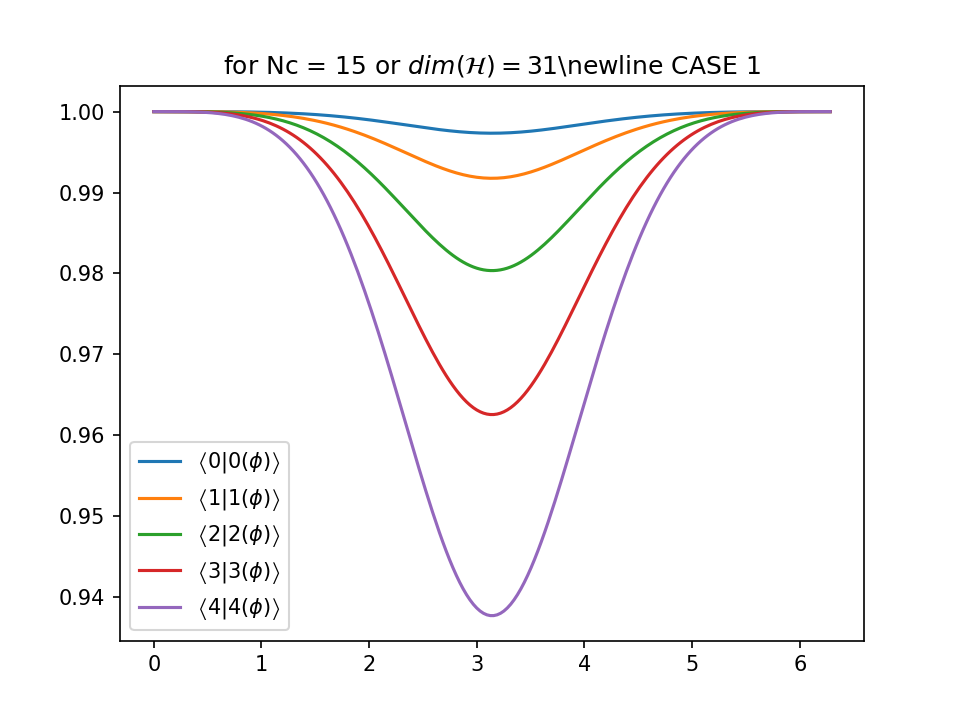

Text(0.5, 1.0, 'for Nc = 15 or $dim(\\mathcal{H}) = 31$\\newline CASE 1')

In [42]:
tr1 = Transmon(Ec1, Ej1, alpha, phi=phi_arr, Nc=Nc, eigspace_N=eigspace_N)
sols1 = tr1.solve(case=1)
res_list1 = np.array([sol.evecs for sol in sols1])

fig, ax = plt.subplots(1,1)
goodness1 = np.zeros((n_entries, eigspace_N), dtype=complex)

for i in range(n_entries):
    for j in range(eigspace_N):
        goodness1[i,j] = np.abs((res_list1[i,j].dag() * res_list1[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness1.T):
    ax.plot(phi_arr, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31$\newline CASE 1")

## Eigenvectors projection on self. Case II: potential well shifts from flux

__**Case II**__
*utilizing static quantization of transmon by Koch et.al https://doi.org/10.1103/PhysRevA.76.042319*
$$ H = E_C n^2 - E_J sgn({cos{(\phi_{ext})}}) \sqrt{1 + \alpha^2 + 2 \alpha \cos{\phi_{ext}}} \cos{\left( \phi - \phi_0 \right) } $$
where $\phi_0 = \arctan{\left( d \tan{\phi_{ext}} \right)} $ and $d = \frac{1-\alpha}{1+\alpha}$ <br> 

case 2


<IPython.core.display.Javascript object>


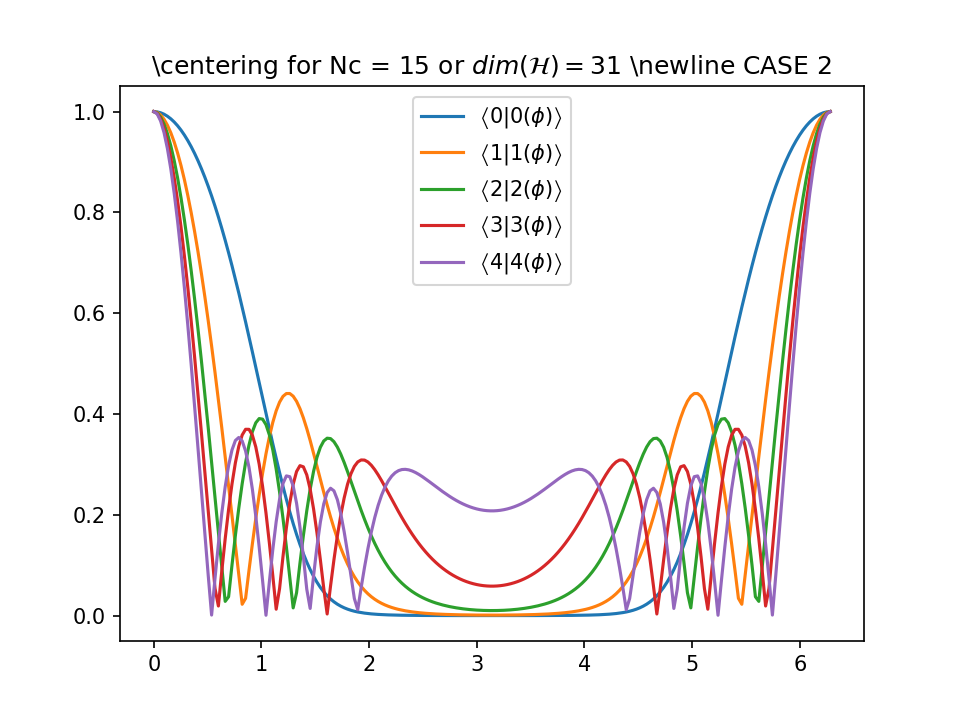

Text(0.5, 1.0, '\\centering for Nc = 15 or $dim(\\mathcal{H}) = 31$ \\newline CASE 2')

In [41]:
tr2 = Transmon(Ec1, Ej1, alpha, phi=phi_arr, Nc=Nc, eigspace_N=eigspace_N)
sols2 = tr2.solve(case=2)
res_list2 = np.array([sol.evecs for sol in sols2])

fig, ax = plt.subplots(1,1)
goodness2 = np.zeros((n_entries, eigspace_N), dtype=complex)

for i in range(n_entries):
    for j in range(eigspace_N):
        goodness2[i,j] = np.abs((res_list2[i,j].dag() * res_list2[0,j])[0,0])
        
for vec_idx, vec_goodness in enumerate(goodness2.T):
    ax.plot(phi_arr, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"\centering for Nc = 15 or $dim(\mathcal{H}) = 31$ \newline CASE 2")

### Case I and Case II E01 energy comparison

<IPython.core.display.Javascript object>


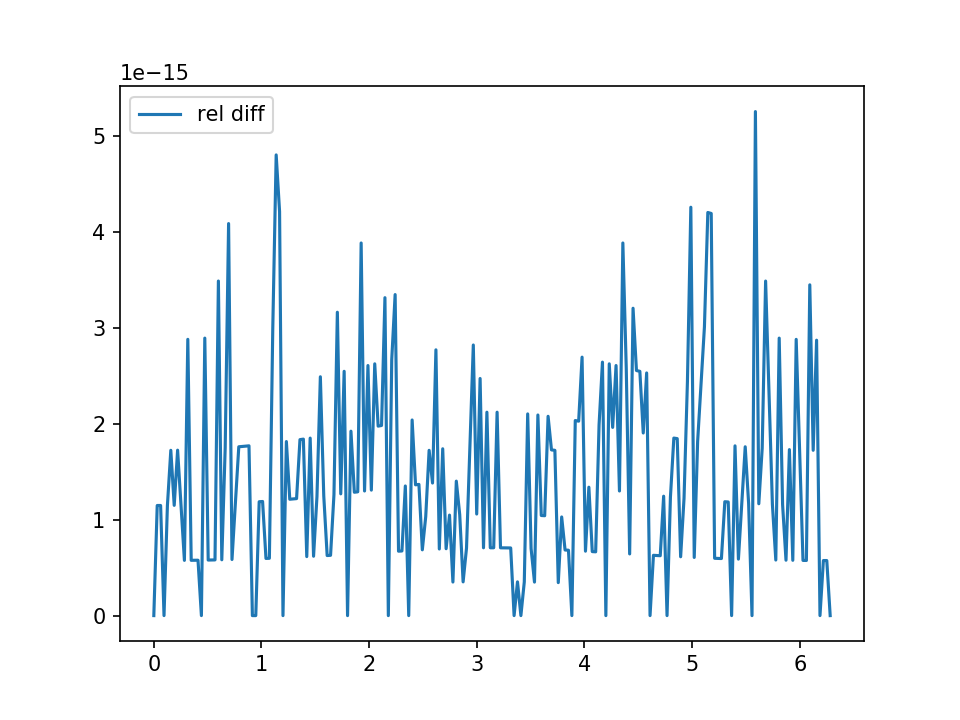

C:\Users\botan\.conda\envs\qp-nbs\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [43]:
# plt.rcParams['text.usetex'] = True
w01_1 = np.array([sol.w01() for sol in sols1])
w01_2 = np.array([sol.w01() for sol in sols2])
fig, ax = plt.subplots(1,1)
ax.plot(phi_arr, np.abs(w01_1 - w01_2)/w01_1, label="rel diff")
ax.legend()

## Eigenvectors projection on self Case III

**Case III**
*utilizing You, X.,et.al (Koch included) (2019). https://doi.org/10.1103/PhysRevB.99.174512*

Written in branch variables *branch* fluxes (G. Burkard et. al 2004 https://journals.aps.org/prb/abstract/10.1103/PhysRevB.69.064503) instead of *node* fluxes (Devoret). Each branch is oriented and each loop is oriented as well. Their relative orientation is captured by *mesh matrix* $\mathbf{R}$:
$$ \left( \mathbf{R} \right)_{i,j} = \cases{
1  \;\;\;\; \Phi_j \in L_i, \text{cooriented branch and loop}\\
-1 \;\;\; \Phi_j \in L_i, \text{contraoriented branch and loop}\\
0 \;\;\;\; \Phi_j \notin L_i, \text{loop does include branch}\\
} $$

R matrix connects branch fluxes and loops fluxes as follows:

$$ \Phi_e(t)_i = \left(\mathbf{R}\right)_{i,j} \; \mathbf{\Phi}(t)_j $$
where $ \Phi_e(t)_i $ - flux through i-th loop (i goes from 1 to F - mesh number of a circuit).<br>
Mesh - set of loops where each loop does not contain other loop<br>
and $\mathbf{\Phi}(t)_j$ - branch flux of j-th branch

Due to the fact that we have F contraints for branch fluxes generated by $\mathbf{R}$ above we will declare new (N-F) flux variables  $\tilde{\mathbf{\Phi}}$:
$$ \tilde{\mathbf{\Phi}} = \mathbf{M} \mathbf{\Phi} $$
where $\mathbf{M}$ - is (N-F)xN matrix that is to be found to eliminate $\dot{\Phi}_e(t)_i$ resulting Hamiltonian.

Declaring new vector
$$\tilde{\mathbf{\Phi}}_{+} = \left( 
\matrix{
\tilde{\mathbf{\Phi}} \\
\mathbf{\Phi}_e
}
\right)
$$

and the new matrix
$$\mathbf{M}_{+} = \left( 
\matrix{
\mathbf{M} \\
\mathbf{R}
}
\right)
$$

we can write down both degrees of freedom and constraints as a single equation:

$$\tilde{\mathbf{\Phi}}_{+} = \mathbf{M}_{+} \mathbf{\Phi} $$

kinetic energy in branch represention (N branches):
$$ \mathcal{L}_k = \frac{1}{2}\dot{\mathbf{\Phi}}^T \mathbf{C} \dot{\mathbf{\Phi}} $$
where $ \mathbf{C} = diag\left(C_1, C_2, ..., C_N\right) $ matrix of branches capacitances.

Moving towards canonical variables and external fluxes:
$$\dot{\mathbf{\Phi}} = \mathbf{M}_{+}^{-1} \dot{\tilde{\mathbf{\Phi}}}_{+} $$
<br>
$$ \mathcal{L}_{\text{K}} = \frac{1}{2}\dot{\tilde{\mathbf{\Phi}}}_{+}^T \mathbf{C}_{\text{eff}} \dot{\tilde{\mathbf{\Phi}}}_{+} $$
where 
$$\mathbf{C_{eff}} = (\mathbf{M}_{+}^{-1})^T \mathbf{C} \left(\mathbf{M}_{+}^{-1}\right) $$

Since we wish to decouple $\dot{\tilde{\mathbf{\Phi}}}$ and $\dot{\mathbf{\Phi}}_e$
than $\mathbf{C}_eff$ has to be block-diagonal with blocks (N-F)x(N-F) and FxF.
Former corresponding to kinetic energy based on new canonical variables $\dot{\tilde{\mathbf{\Phi}}}$ and the latter will be excluded from Lagrangian as a total derivative of time only dependent function.<br>
Block-diagonal requirement is also applies to the inverse of $\mathbf{C}_{\text{eff}}$:

$$ \mathbf{C}_{\text{eff}}^{-1} =  (\mathbf{M}_{+})^T \mathbf{C}^{-1} \left(\mathbf{M}_{+}\right) = \left( 
\matrix{
\mathbf{M^T} & \mathbf{R^T}
}
\right)
\mathbf{C}^{-1}
\left(
\matrix{
\mathbf{M}\\
\mathbf{R}
}
\right) = 
\left(
\matrix{
\mathbf{M}\mathbf{C}^{-1}\mathbf{M} & \mathbf{M}\mathbf{C}^{-1}\mathbf{R}^T \\
\mathbf{R}\mathbf{C}^{-1}\mathbf{M} & \mathbf{R}\mathbf{C}^{-1}\mathbf{R}
}
\right)
$$

Hence we have to find atleast one matrix that satisfy:
$$\mathbf{R}\mathbf{C}^{-1}\mathbf{M}^T = 0$$

Speaking in terms of linear argebra: rows of $\mathbf{M}$ is the null space of $\mathbf{R}\mathbf{C}^{-1}$ operator.

Consider the following schematics where leftmost JJ is substituted with simple capacitor C

![title](Case_3.png)

$$\mathbf{R} = 
\left(
\matrix{
1 & -1 & 0 \\
0 & 1 & -1
}
\right)
$$
$$\mathbf{C}^{-1} = diag\left( C_1^{-1},C_2^{-1},C_{3}^{-1} \right)$$
$$ \mathbf{R} \mathbf{C}^{-1} = 
\left(
\matrix{
C_1^{-1} & -C_2^{-1} & 0 \\
0 & C_2^{-1} & C_3^{-1}
}
\right)
$$
<br>
from here we can deduce that (properly normalized by $C_{\Sigma} = \Sigma C_i$:
$$ M = \frac{1}{C_{\Sigma}}
\left(
\matrix{C_1 & C_2 & C_3 } 
\right) $$

Finally we have only one "free" branch variable: <br>
$ \tilde{\phi} = \mathbf{M} \mathbf{\Phi} $

<br>
Finding equation for $\mathbf{C}_{\text{eff}}$:

$$ \mathbf{M}_{+} = 
\left(
\matrix{
\mathbf{M} \\
\mathbf{R}
}
\right) =
\left(
\matrix{
\frac{C_1}{C_{\Sigma}} & \frac{C_2}{C_{\Sigma}} & \frac{C_2}{C_{\Sigma}}\\
1 & -1 & 0 \\
0 & 1 & -1
}
\right)
$$

$$ (\mathbf{M}_{+})^{-1} = 
\left(
\matrix{
1 & \frac{C_2 + C_3}{C_{\Sigma}} & \frac{C_3}{C_{\Sigma}} \\
1 & -\frac{C_1}{C_{\Sigma}} & \frac{C_3}{C_{\Sigma}} \\
1 & -\frac{C_1}{C_{\Sigma}} & -\frac{C_1 + C_2}{C_{\Sigma}}
}
\right) $$

<br>
And finally
$$\mathbf{C}_{\text{eff}} = 
\left(
\matrix{
C_{\Sigma} & 0 & 0 \\
0 & \frac{C_1(C_2 + C_3)}{C_{\Sigma}} & \frac{C_1 C_3}{C_{\Sigma}} \\
0 & \frac{C_1 C_3}{C_{\Sigma}} &\frac{(С_1+С_2)C_3}{C_{\Sigma}}
}
\right)
$$

$$\mathbf{\Phi} = \mathbf{M}_{+}^{-1} \tilde{\mathbf{\Phi}}_{+} $$
or

$$ \left(
\matrix{ 
\Phi_1 \\
\Phi_2 \\
\Phi_3
}
\right) = 
(\mathbf{M}_{+})^{-1} 
\left(\matrix{ 
\tilde{\phi} \\
\Phi_e^1 \\
\Phi_e^2
}
\right) $$

Total Hamiltonian in this case will be

$$ H =  E_C n^2 - 
E_{J2}\cos{\left( \tilde{\phi} -\frac{C_1}{C_{\Sigma}}\Phi_e^{1} + \frac{C_3}{C_{\Sigma}}\Phi_e^{2} \right)} 
- E_{J3}\cos{\left(\tilde{\phi}  -\frac{C_1}{C_{\Sigma}}\Phi_e^{1} -\frac{C_1 + C_2}{C_{\Sigma}}\Phi_e^{2}\right)} $$
where $E_C = 2e^2/C_{\Sigma}$

or in notation of Tmon:
$$ H =  E_C n^2 - 
E_{J1}\cos{\left( \tilde{\phi} -\frac{C_{sh}}{C_{\Sigma}}\Phi_e^{1} + \frac{C_{J2}}{C_{\Sigma}}\Phi_e^{2} \right)} 
- E_{J2}\cos{\left(\tilde{\phi}  -\frac{C_{sh}}{C_{\Sigma}}\Phi_e^{1} -\frac{C_{sh} + C_{J1}}{C_{\Sigma}}\Phi_e^{2}\right)} $$

## Z-gate

In [144]:
import transmon_simulations_lib.single_transmon.transmon
reload(transmon_simulations_lib.single_transmon.transmon)
from transmon_simulations_lib.single_transmon.transmon import Transmon

In [286]:
import scipy.signal
def gauss(t, t0, gdt):
    import scipy.stats
    gauss_hat_centered = scipy.stats.norm(t0, gdt).pdf(t)
    return gauss_hat_centered

def phi(t, start, tau, gdt):
    phi = np.zeros(t.shape)
    phi[((t > start) & (t < start + tau))] = 1
    if gdt != 0:
        phi = scipy.signal.convolve(phi,gauss(t, t[-1]/2, gdt),mode='same')
    return phi

<IPython.core.display.Javascript object>


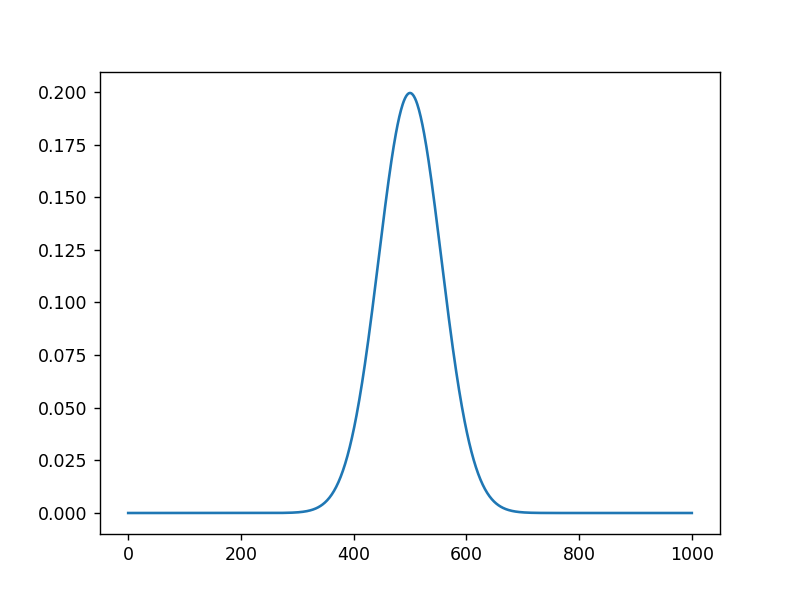

(0.9544997361036417, 1.840356045641613e-11)

In [294]:
fix, ax = plt.subplots(1,1)
pdata = gauss(Ts,Ts[-1]/2, 2)
ax.plot(pdata)
scipy.integrate.quad(lambda x: gauss(x,Ts[-1]/2,2), Ts[-1]/2 - 4, Ts[-1]/2 + 4)

pulse preparation

<IPython.core.display.Javascript object>


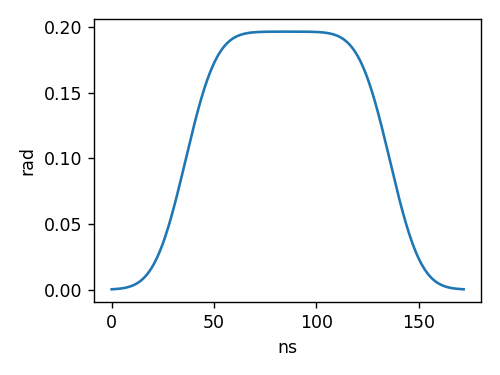

In [382]:

tau = 100  # Gate length
dgt = 12   # typical rise-fall time of the pulse
t_rise = 3*dgt  # several rise-fall times to ensure most pulse is in window
t_start = t_rise  # severak rise-fall times
Ts = np.linspace(0,t_rise + tau + t_rise,1001)
phi_list = phi(Ts, t_start, tau, dgt)
phi_list *= np.pi/16/np.max(phi_list)
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(Ts, phi_list)
ax.set_xlabel("ns")
ax.set_ylabel("rad")
fig.tight_layout()

### Case I

In [391]:
tr = Transmon(Ec1, Ej1, alpha=alpha, phi=0, Nc=10)
first_evecs_N = 5
first_evecs = tr.solve()[0].evecs[:first_evecs_N]
H_list = [tr.calc_Hfull_cb(phi) for phi in phi_list]
def H_callback(t, *args):
    i = np.argmin(np.abs(t-Ts))
    return H_list[i]
def H_0_callback(t, *args):
    return H_list[0]
sol = qp.sesolve(H_callback, psi1, Ts, options=qp.Options(nsteps=10000))

use 1


<IPython.core.display.Javascript object>


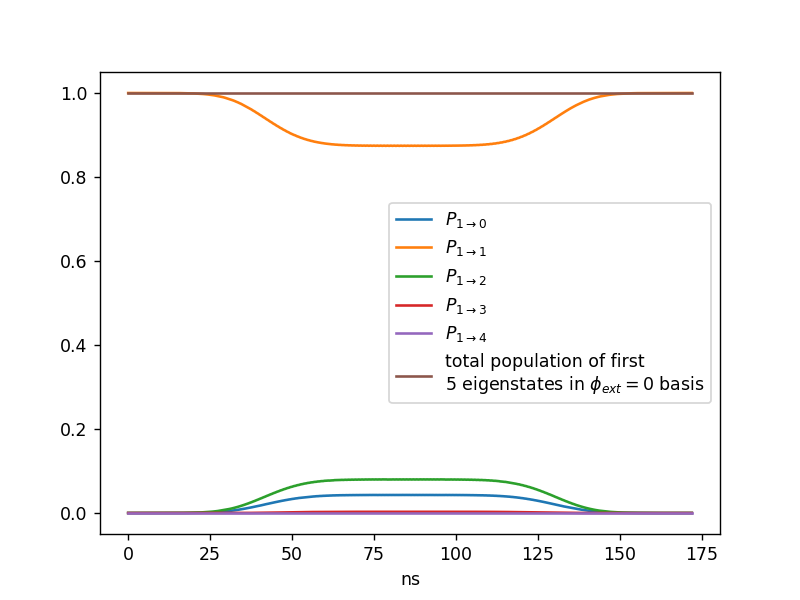

(-0.05, 1.05)

In [392]:
fig, ax = plt.subplots(1,1)

projs = []
for evec in first_evecs:
    bra_vec = evec.dag()
    projs.append(np.array([(bra_vec*state_ket)[0,0] for state_ket in sol.states]))
projs = np.array(projs)

for i, proj in enumerate(projs):
    label_str = r"$P_{1 \rightarrow " + f"{i}" + r" }$"
    ax.plot(Ts, np.abs(proj)**2, label=label_str)
s = np.sum(np.abs(projs)**2, axis=0)
ax.plot(Ts, s, label="total population of first \n" + str(len(projs)) + r" eigenstates in $\phi_{ext} = 0$ basis")
ax.legend()
ax.set_xlabel("ns")
ax.set_ylim(-0.05, 1.05)

### Case II

In [385]:
tr = Transmon(Ec1, Ej1, alpha=alpha, phi=0, Nc=10)
first_evecs_N = 5
first_evecs = tr.solve()[0].evecs[:first_evecs_N]
H_list = [tr.calc_Hfull_cb2(phi) for phi in phi_list]
def H_callback(t, *args):
    i = np.argmin(np.abs(t-Ts))
    return H_list[i]
def H_0_callback(t, *args):
    return H_list[0]
sol = qp.sesolve(H_callback, psi1, Ts, options=qp.Options(nsteps=10000))

use 1


<IPython.core.display.Javascript object>


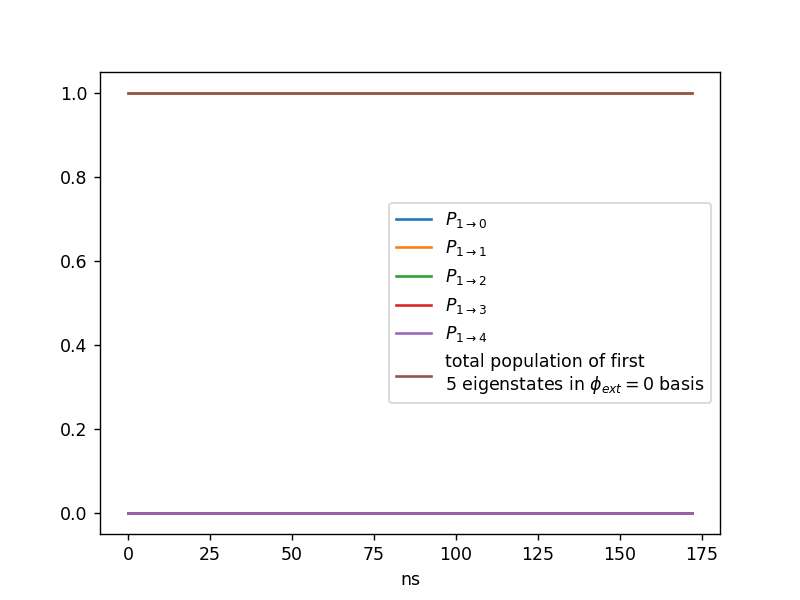

(-0.05, 1.05)

In [389]:
fig, ax = plt.subplots(1,1)

projs = []
for evec in first_evecs:
    bra_vec = evec.dag()
    projs.append(np.array([(bra_vec*state_ket)[0,0] for state_ket in sol.states]))
projs = np.array(projs)

for i, proj in enumerate(projs):
    label_str = r"$P_{1 \rightarrow " + f"{i}" + r" }$"
    ax.plot(Ts, np.abs(proj)**2, label=label_str)
s = np.sum(np.abs(projs)**2, axis=0)
ax.plot(Ts, s, label="total population of first \n" + str(len(projs)) + r" eigenstates in $\phi_{ext} = 0$ basis")
ax.legend()
ax.set_xlabel("ns")
ax.set_ylim(-0.05, 1.05)

# Not sorted

In [ ]:
# qubit 1 jumps from phi = 0 to phi = pi/2 and back
# qubit 2 resides in phi = pi/2
phi_list_cache = np.linspace(0, np.pi/2, int(1e2))

if __name__ == '__main__':
    mp.freeze_support()
    args = []
from single_transmon.transmon import foo
def foo(args):
    return args["phi_offset"]
for phi in phi_list_cache:
    args.append({"phi_offset": phi})
with mp.Pool(mp.cpu_count()-1) as p:
    res = list(p.map(foo, tqdm.tqdm(args)))

In [ ]:
chain = TransmonChain(4, transmon_truncation = 3)
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],0.6,0.7))
chain._transmons = [tr1, tr2,tr3,tr4]
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5])
chain.build_low_energy_kets(2,0)
chain._Ts = Ts
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.rho0 = rho0
sigma_z_chain = []
sigma_x_chain = []
sigma_y_chain = []
for i in range (4): #TO DO - вынести в функцию класса
    sigma_z = chain._transmons[i].sz()
    sigma_x = chain._transmons[i].sx()
    sigma_y = chain._transmons[i].sy()
    oper_z = chain._identity_array.copy()
    oper_z[i]=sigma_z
    oper_x = chain._identity_array.copy()
    oper_x[i]=sigma_x
    oper_y = chain._identity_array.copy()
    oper_y[i]=sigma_y
    sigma_z_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_z)))
    sigma_x_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_x)))
    sigma_y_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_y)))

chain.e_ops = sigma_z_chain + sigma_x_chain + sigma_y_chain


# Свободная эволюция системы

### 1й и 2й кубит в цепочке в резонансе, изначально первый кубит возбуждён

In [ ]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0[0] = ket2dm((basis(3,1) + basis(3,0))/sqrt(2)) # задаём начальное состояние 1го кубита
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
waveform1_const = ones_like(Ts)*(params['phi_base_level']+params['phi_offset'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7


H_full_test = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full_test, rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

In [ ]:
chain.plot_chain_dynamic(result)

## Эволюция под действием внешнего поля

### Кубиты не в резонансе, поле действует на первый и третий кубиты

In [ ]:
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))

In [ ]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7

In [ ]:
H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[T._pi_duration/2,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

### 1й, 2й и 3й кубиты в резонансе, поле действует на первый

In [ ]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'] + params['phi_offset'] )
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform4_const = ones_like(Ts)*0.7
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],params['phi2z_base_level'],0.7))

H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Vacuum rabi oscillations

Приготавливаем первый кубит в возбуждённом состоянии, затем на какое-то время перестраиваем его по потоку. При попадании в резонанс со вторым кубитом наблюдаются осцилляции заселённости возбуждённого состояния 1-го и 2-го кубитов. Можно построить зависимость заселённости второго кубита от отстройки по потоку и времени взаимодействия. 

In [ ]:
signal = ZPulse(Ts,params)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))



## Форма потокового импульса, подающегося на первый кубит (для одного значения параметров)

In [ ]:
figure()
plot(Ts, vacuum_rabi_waveform(200, 0.03, Ts, params)[0])

In [ ]:
##special for windows 
durations = linspace (50, 250, 50)
phis = linspace (0.025, 0.035, 200)
size = len(phis)
args = []
for ind, phi in enumerate (phis):
    dict_arg = {'chain' : chain, 'params' : params, 'durations' : durations, 'phi_offset' : phi}
    args.append(dict_arg)
    
if __name__=='__main__':
    with Pool(4) as p:
        populations = p.map(vacuum_rabi_populations_one_phi_windows, tqdm(args))

In [ ]:
figure()
pcolormesh(durations, phis, populations)
colorbar()
#savefig('01.12.2021_vacuum_rabi_4q.png')

## Iswap Gate

Пример эволюции кубитов при проведении гейта i-swap, первый кубит изначально переводится в состояние на экваторе сферы блоха, 
далее первый и второй кубиты переводятся в резонанс, после этого проводится фазовая коррекция с помощью Z-гейта.  

In [ ]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0,0,0])
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)
waveform2 = signal.waveform_iswap_zgate(2)
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7
H_full = chain.build_H_full([waveform1, waveform2, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration/2,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Спектр системы в зависимости от потока через первый кубит

In [ ]:
levels = []

phis = linspace(0, 1, 3000)
for phi in tqdm(phis):
    phi_arr = [0.25, .5 , .6, .7]
    phi_arr[0] = phi
    chain.set_phi(phi_arr)
    waveform1_const = ones_like(Ts)*phi_arr[0]
    waveform2_const = ones_like(Ts)*phi_arr[1]
    waveform3_const = ones_like(Ts)*phi_arr[2]
    waveform4_const = ones_like(Ts)*phi_arr[3]
    H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]])
    H_const = chain.truncate_to_low_population_subspace(chain._zero_op)
    for i in range (12):
        if (i%3 != 2):
            H_const+=H_full[i][0]*H_full[i][1][0]
    for i in range(13,19,1):
        H_const+=H_full[i][0]
    evals, evecs = H_const.eigenstates()
    levels.append((evals-evals[0])/2/pi)

In [ ]:
figure()
plot(phis, array(levels)[:, 1:6])
plot(phis, array(levels)[:, 6:21]/2, "--")